Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial #2:  Deploy an image classification model in Azure Container Instance (ACI)

This tutorial is **part two of a two-part tutorial series**. In the [previous tutorial](img-classification-part1-training.ipynb), you trained machine learning models and then registered a model in your workspace on the cloud.  

Now, you're ready to deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/azure/container-instances/) (ACI). A web service is an image, in this case a Docker image, that encapsulates the scoring logic and the model itself. 

ACI is a great solution for testing and understanding the workflow. For scalable production deployments, consider using Azure Kubernetes Service. For more information, see [how to deploy and where](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

## Set up the environment

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
import azureml.core

# display the core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.69


In [8]:
from azureml.core import Workspace
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

TestMLWS	northeurope	TestMLWS


## Register a local model

In [9]:
from azureml.core.model import Model
model = Model.register(model_path="sklearn_mnist_model.pkl",
                       model_name="sklearn_mnist_local",
                       tags={"data": "mnist", "model": "classification"},
                       description="Mnist handwriting recognition",
                       workspace=ws)

Registering model sklearn_mnist_local


## Retrieve the trained model from your Machine Learning Workspace

You registered a model in your workspace in the previous tutorial. Now, load this workspace and download the model to your local directory.

In [10]:
import os 
from azureml.core.model import Model

model=Model(ws, 'sklearn_mnist')
model.download(target_dir=os.getcwd(), exist_ok=True)

# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")
os.stat(file_path)

os.stat_result(st_mode=33279, st_ino=14717807562711891968, st_dev=45, st_nlink=1, st_uid=0, st_gid=0, st_size=63682, st_atime=1571936121, st_mtime=1571936411, st_ctime=1571936411)

In [11]:
print(model.name, model.description, model.version, sep = '\t')

sklearn_mnist	None	6


## Deploy as web service

Once you've tested the model and are satisfied with the results, deploy the model as a web service hosted in ACI. 

To build the correct environment for ACI, provide the following:
* A scoring script to show how to use the model
* An environment file to show what packages need to be installed
* A configuration file to build the ACI
* The model you trained before

### Create scoring script

Create the scoring script, called score.py, used by the web service call to show how to use the model.

You must include two required functions into the scoring script:
* The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started. 

* The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.


In [12]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Writing score.py


### Create environment file

Next, create an environment file, called myenv.yml, that specifies all of the script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image. This model needs `scikit-learn` and `azureml-sdk`.

In [13]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

Review the content of the `myenv.yml` file.

In [14]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

- scikit-learn
channels:
- conda-forge



### Create configuration file

Create a deployment configuration file and specify the number of CPUs and gigabyte of RAM needed for your ACI container. While it depends on your model, the default of 1 core and 1 gigabyte of RAM is usually sufficient for many models. If you feel you need more later, you would have to recreate the image and redeploy the service.

In [15]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

### Deploy in ACI
Estimated time to complete: **about 7-8 minutes**

Configure the image and deploy. The following code goes through these steps:

1. Build an image using:
   * The scoring file (`score.py`)
   * The environment file (`myenv.yml`)
   * The model file
1. Register that image under the workspace. 
1. Send the image to the ACI container.
1. Start up a container in ACI using the image.
1. Get the web service HTTP endpoint.

In [16]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml")

service = Model.deploy(workspace=ws, 
                       name='sklearn-mnist-svc', 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aciconfig)

service.wait_for_deployment(show_output=True)

Running.......................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 271 ms, sys: 59 ms, total: 330 ms
Wall time: 2min 3s


Get the scoring web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [17]:
print(service.scoring_uri)

http://8abb772f-a950-4d9e-9e48-b6ab1936842d.northeurope.azurecontainer.io/score


## Test deployed service

Earlier you scored all the test data with the local version of the model. Now, you can test the deployed model with a random sample of 30 images from the test data.  

The following code goes through these steps:
1. Send the data as a JSON array to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

1. Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples. 

 Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

In [19]:
from utils import load_data
import os

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

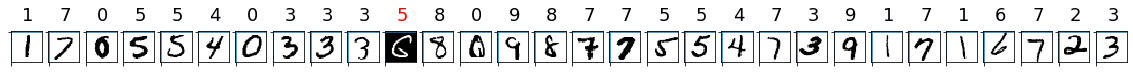

In [20]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

You can also send raw HTTP request to test the web service.

In [21]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

POST to url http://8abb772f-a950-4d9e-9e48-b6ab1936842d.northeurope.azurecontainer.io/score
label: 6
prediction: [6]


## Clean up resources

To keep the resource group and workspace for other tutorials and exploration, you can delete only the ACI deployment using this API call:

In [22]:
service.delete()


If you're not going to use what you've created here, delete the resources you just created with this quickstart so you don't incur any charges. In the Azure portal, select and delete your resource group. You can also keep the resource group, but delete a single workspace by displaying the workspace properties and selecting the Delete button.


## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your testing environment
> * Retrieve the model from your workspace
> * Test the model locally
> * Deploy the model to ACI
> * Test the deployed model
 
You can also try out the [regression tutorial](regression-part1-data-prep.ipynb).

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/tutorials/img-classification-part2-deploy.png)